In [13]:


from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ReLU,LeakyReLU
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  
from PIL import Image
import argparse
import math

In [14]:
# import argparse
# # 创建解析
# parser = argparse.ArgumentParser(description="train flower classify",
#                                  formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# # 添加参数
# parser.add_argument('--train_url', type=str,
#                     help='the path model saved')
# parser.add_argument('--data_url', type=str, help='the training data')
# # 解析参数
# args, unkown = parser.parse_known_args()

# data_path = args.data_url
# train_path = args.train_url
data_path = './'
train_path = './GAN/'
image_shape = (32, 32, 1)

In [15]:
def combine_images(generated_images):
    #生成图片拼接
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [16]:
class WGAN_GP():
    def __init__(self,input_shape):
        self.noise_size = 128
        self.input_shape = input_shape
        
        #discriminator setting and implementation
        self.n_critic = 5
        self.LAMBDA = 10.0
        self.critic = self.build_critic()
        self.critic.trainable = False
        self.optimizer_critic = Adam(
            learning_rate=0.0001,
            beta_1=0.5,
            beta_2=0.9
        )

        #generator setting and implementation
        self.generator = self.build_generator()
        
        #complete model
        self.model = Model(
            self.generator.input,
            self.critic(self.generator.output)
        )
        self.model.compile(
            loss=self.dis_wasserstein,
            optimizer=Adam(
                learning_rate=0.0001,
                beta_1=0.5,
                beta_2=0.9
            )
        )

    #simply return mean to reperesent expectation
    def dis_wasserstein(self,y_true,y_pred):
        return tf.math.reduce_mean(y_true * y_pred)

    def build_critic(self):
        model = Sequential(name='critic')
        DIM = 64
        model.add(Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(LeakyReLU(0.2))
        model.add(Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(LeakyReLU(0.2))
        model.add(Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dense(1))
        return model

    def build_generator(self):
        model = Sequential(name='Generator')
        DIM = 64
        model.add(Input(shape=[self.noise_size])) 
        model.add(Dense(4*4*4*DIM))
        model.add(ReLU())
        model.add(Reshape((4,4,4*DIM)))
        model.add(UpSampling2D((2,2), interpolation='bilinear'))
        model.add(Conv2D(2*DIM, 5, padding='same'))
        model.add(ReLU())
        model.add(UpSampling2D((2,2), interpolation='bilinear'))
        model.add(Conv2D(2*DIM, 5, padding='same'))
        model.add(ReLU())
        model.add(UpSampling2D((2,2), interpolation='bilinear'))
        model.add(Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))
        return model

    def gradient_penalty(self,grad):
        grad_norm = tf.math.sqrt(
            tf.math.reduce_sum(
                tf.math.square(
                    grad
                )
            )
        )
        grad_pen = self.LAMBDA * tf.math.reduce_mean(
            tf.math.square(
                grad_norm-1
            )
        )
        return grad_pen
    
    def train_critic(self,real_images,batch_size):
        self.critic.trainable = True
        noise = tf.random.normal(
            (batch_size,self.noise_size)
        )
        gen_images = self.generator.predict(noise)

        with tf.GradientTape() as gp_tape, tf.GradientTape() as critic_tape:
            gen_pred = self.critic(gen_images)
            real_pred = self.critic(real_images)
            
            #cal loss
            gen_dis = tf.cast(tf.math.reduce_mean(gen_pred),tf.float64)
            real_dis = tf.cast(tf.math.reduce_mean(real_pred),tf.float64)
            # print(gen_images[1].shape())
            # print(real_images[1].shape())
            difference = gen_images - real_images
            alpha =  tf.random.uniform(
                shape=[batch_size,1,1,1],
                minval=0.,
                maxval=1.,
                dtype=np.float64
            )

            interpolates = real_images + tf.math.multiply(alpha,difference)
            gp_tape.watch(interpolates)
            gradients_interpolates = gp_tape.gradient(
                self.critic(interpolates),
                [interpolates]
            )
            gradients_penalty = self.gradient_penalty(
                gradients_interpolates
            )

            d_loss = gen_dis - real_dis + gradients_penalty
            
            #update data
            gradients_d = critic_tape.gradient(
                d_loss,
                self.critic.trainable_variables
            )
            self.optimizer_critic.apply_gradients(
                zip(
                    gradients_d,
                    self.critic.trainable_variables
                )
            )
        self.critic.trainable = False
        return gen_dis, real_dis, gradients_penalty
    
    def train_generator(self,batch_size):
        noise = tf.random.normal(
            (batch_size,self.noise_size)
        )
        gen_labels = -tf.ones(batch_size)
        return self.model.train_on_batch(noise,gen_labels)

    def train_model(self,dataset,batch_size,epochs,checkpoint):
        val_noise1 = tf.random.normal(
            (batch_size,self.noise_size)
        )
        g_losslist = []
        d_losslist = []
        data_generator = iter(dataset)
        cnt = 1
        for epoch in range(epochs):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                cnt += 1
                if cnt == 900:
                    data_generator = iter(dataset)
                    cnt = 1
                loss_gen, loss_real, gradients_penalty = self.train_critic(
                    real_images,
                    batch_size    
                )
                d_loss = (loss_gen - loss_real + gradients_penalty)
            g_loss = self.train_generator(
                batch_size
            )
            g_losslist.append(g_loss)
            d_losslist.append(-np.float64(d_loss))
            if epoch % checkpoint == 9:
                msg = "In epoch "+str(epoch)+",g_loss is "+str(g_loss)+",d_loss is "+str(d_loss)
                print(msg)
                val_noise2 = tf.random.normal(
                    (batch_size,self.noise_size)
                )
                val_images1 = self.generator.predict(
                    val_noise1,
                    verbose=0
                )
                val_images2 = self.generator.predict(
                    val_noise2,
                    verbose=0
                )
                image1 = combine_images(val_images1)
                image1 = image1*127.5+127.5
                Image.fromarray(image1.astype(np.uint8)).save(
                    train_path+str(epoch)+"_stable"+".png")
                image2 = combine_images(val_images2)
                image2 = image2*127.5+127.5
                Image.fromarray(image2.astype(np.uint8)).save(
                    train_path+str(epoch)+"_flexible"+".png")
                
        plt.plot(g_losslist, label='g_loss')
        plt.plot(d_losslist, label = 'd_loss')
        plt.xlabel('Epoch')
        plt.ylabel('loss')
        plt.ylim(bottom=0)
        plt.legend(loc='lower right')
        plt.savefig(train_path + 'lossplt.png')


In [17]:
#preprocess
(train_images, train_labels), (_, _) = mnist.load_data(data_path+'mnist.npz')
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
image_shape = (32,32,1)

train_images_pre = np.ndarray(train_images.shape[0] * 32 * 32 *1).reshape(train_images.shape[0],32,32,1)
for i in range(len(train_images_pre)):
    train_images_pre[i] = tf.image.resize(train_images[i], (32,32))
train_images = train_images_pre 
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_images = train_images[0:59968]
BUFFER_SIZE = 60000
BATCH_SIZE = 64
EPOCHS = 5000
CHECKPOINT = 200
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# print(len(train_dataset))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

In epoch 9,g_loss is 1.5387449,d_loss is tf.Tensor(-2.432331381378874, shape=(), dtype=float64)
In epoch 209,g_loss is 1.8421643,d_loss is tf.Tensor(-2.4801861053146625, shape=(), dtype=float64)
In epoch 409,g_loss is 1.8721163,d_loss is tf.Tensor(-2.5668077443779787, shape=(), dtype=float64)
In epoch 609,g_loss is 0.118517205,d_loss is tf.Tensor(-1.1195926404055885, shape=(), dtype=float64)
In epoch 809,g_loss is -0.060747005,d_loss is tf.Tensor(-0.8674107119644012, shape=(), dtype=float64)
In epoch 10

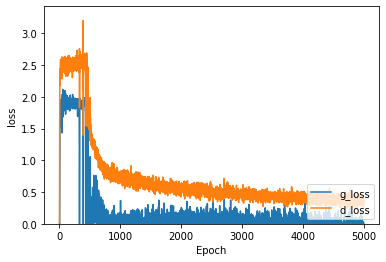

In [18]:
wgan_gp = WGAN_GP(image_shape)
# wgan_gp.model.summary()
# wgan_gp.critic.summary()
wgan_gp.train_model(
    train_dataset,
    BATCH_SIZE,
    EPOCHS,
    CHECKPOINT
)



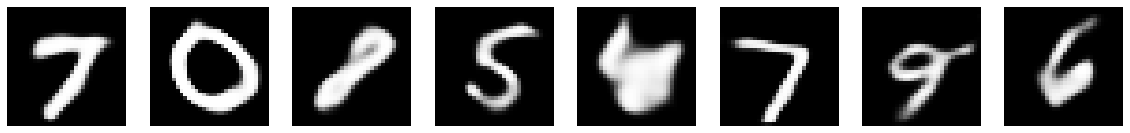

In [23]:
def plot_images(images):   
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2.5, grid_row*2.5))
        for row in range(grid_row):
            for col in range(grid_col):
                axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                axarr[col].axis('off') 
        plt.show()

z = tf.random.normal((8, 128))
generated_images = wgan_gp.generator.predict(z)
plot_images(generated_images)